![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 14 - Auto-encoders </center>
### <center> Convolutional Auto-encoders </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/14_AutoEncoders/MainAutoEncoder.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import torch
import torch.nn          as nn
import torch.optim       as optim
import torchinfo

For Colab users:

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/14_AutoEncoders/DeepLearningFramework ./DeepLearningFramework

#### Load MNIST data:

In [5]:
import torchvision.transforms as transforms
import torchvision

dataPath  = '../../data/'
oTrainSet = torchvision.datasets.MNIST(root=dataPath, train=True,  transform=transforms.ToTensor(), download=True)
oTestSet  = torchvision.datasets.MNIST(root=dataPath, train=False, transform=transforms.ToTensor(), download=True)

In [6]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

mX, _     = next(iter(oTrainDL))
mX.shape

torch.Size([128, 1, 28, 28])

#### Encoder:

In [7]:
def GetEncoder():
    oEncoder = nn.Sequential(
        nn.Identity(),
        nn.Conv2d(1,  8,  kernel_size=3, bias=False), nn.BatchNorm2d(8 ), nn.ReLU(), 
        nn.Conv2d(8,  16, kernel_size=3, bias=False), nn.BatchNorm2d(16), nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=3, bias=False), nn.BatchNorm2d(32), nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, bias=False), nn.BatchNorm2d(64), nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, bias=False), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(64, 64, kernel_size=3, bias=False), nn.BatchNorm2d(64), nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, bias=False), nn.BatchNorm2d(64), nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, bias=False), nn.BatchNorm2d(64), nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, bias=False), nn.BatchNorm2d(64), nn.ReLU(),
        nn.Conv2d(64, 2,  kernel_size=1), 
        nn.Flatten()
    )
    
    return oEncoder

#=============================================================#
#=============================================================#
torchinfo.summary(GetEncoder(), (128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [128, 1, 28, 28]          --
├─Conv2d: 1-2                            [128, 8, 26, 26]          72
├─BatchNorm2d: 1-3                       [128, 8, 26, 26]          16
├─ReLU: 1-4                              [128, 8, 26, 26]          --
├─Conv2d: 1-5                            [128, 16, 24, 24]         1,152
├─BatchNorm2d: 1-6                       [128, 16, 24, 24]         32
├─ReLU: 1-7                              [128, 16, 24, 24]         --
├─Conv2d: 1-8                            [128, 32, 22, 22]         4,608
├─BatchNorm2d: 1-9                       [128, 32, 22, 22]         64
├─ReLU: 1-10                             [128, 32, 22, 22]         --
├─Conv2d: 1-11                           [128, 64, 20, 20]         18,432
├─BatchNorm2d: 1-12                      [128, 64, 20, 20]         128
├─Re

#### Decoder:

In [8]:
from DeepLearningFramework.Layers import Reshape

def GetDecoder():
    oDecoder = nn.Sequential(
        nn.Identity(),
        Reshape([2, 1, 1]),
        nn.Upsample(scale_factor=3), nn.Conv2d(2,  8,  kernel_size=2, padding=1, bias=False), nn.BatchNorm2d(8 ), nn.ReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(8,  16, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(16), nn.ReLU(), 
                                     nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(32), nn.ReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(32, 40, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(40), nn.ReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(40, 40, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(40), nn.ReLU(), 
                                     nn.Conv2d(40, 40, kernel_size=3, padding=0, bias=False), nn.BatchNorm2d(40), nn.ReLU(), 
                                     nn.Conv2d(40, 1,  kernel_size=3),
        nn.Sigmoid(), 
    )

    return oDecoder

#=============================================================#
#=============================================================#
torchinfo.summary(GetDecoder(), (128, 2,))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [128, 2]                  --
├─Reshape: 1-2                           [128, 2, 1, 1]            --
├─Upsample: 1-3                          [128, 2, 3, 3]            --
├─Conv2d: 1-4                            [128, 8, 4, 4]            64
├─BatchNorm2d: 1-5                       [128, 8, 4, 4]            16
├─ReLU: 1-6                              [128, 8, 4, 4]            --
├─Upsample: 1-7                          [128, 8, 8, 8]            --
├─Conv2d: 1-8                            [128, 16, 8, 8]           1,152
├─BatchNorm2d: 1-9                       [128, 16, 8, 8]           32
├─ReLU: 1-10                             [128, 16, 8, 8]           --
├─Conv2d: 1-11                           [128, 32, 8, 8]           4,608
├─BatchNorm2d: 1-12                      [128, 32, 8, 8]           64
├─ReLU: 1

#### Full model (autoencoder):

In [9]:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(),
        GetEncoder (),
        GetDecoder ()
    )
    return oModel

#=============================================================#
#=============================================================#
torchinfo.summary(GetModel(), (128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [128, 1, 28, 28]          --
├─Sequential: 1-2                        [128, 2]                  --
│    └─Identity: 2-1                     [128, 1, 28, 28]          --
│    └─Conv2d: 2-2                       [128, 8, 26, 26]          72
│    └─BatchNorm2d: 2-3                  [128, 8, 26, 26]          16
│    └─ReLU: 2-4                         [128, 8, 26, 26]          --
│    └─Conv2d: 2-5                       [128, 16, 24, 24]         1,152
│    └─BatchNorm2d: 2-6                  [128, 16, 24, 24]         32
│    └─ReLU: 2-7                         [128, 16, 24, 24]         --
│    └─Conv2d: 2-8                       [128, 32, 22, 22]         4,608
│    └─BatchNorm2d: 2-9                  [128, 32, 22, 22]         64
│    └─ReLU: 2-10                        [128, 32, 22, 22]         --
│    └─Co

#### Epoch:

In [11]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, _) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)

        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mHatX = oModel(mX)
            loss  = Loss  (mHatX, mX)
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mHatX = oModel(mX)
                loss  = Loss  (mHatX, mX)

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters
            if oScheduler is not None:
                vLR[ii] = oScheduler.get_last_lr()[0]
                oScheduler.step() #-- update learning rate

        Nb           = mX.shape[0]
        count       += Nb
        epochLoss   += Nb * loss.item()
        epochMetric += Nb * Metric(mHatX, mX)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

### Train the model:

In [10]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel
from DeepLearningFramework.Metric   import R2Score

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
Loss   = nn.MSELoss  ()
Metric = R2Score

In [14]:
nEpochs    = 25
nIter      = nEpochs * len(oTrainDL)

oModel     = GetModel  ().to(DEVICE)
oOptim     = optim.Adam(oModel.parameters(), lr=0, betas=(0.9, 0.99))
oScheduler = OneCycleLR(oOptim, max_lr=4e-3, total_steps=nIter)
lHistory   = TrainModel(oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, Epoch=Epoch, sModelName='AE')

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  0.061 | Val loss:  0.045 | Train Metric:  0.354 | Val Metric:  0.533 | epoch time:  7.788 | <-- Checkpoint!
Epoch 001: | Train loss:  0.043 | Val loss:  0.042 | Train Metric:  0.542 | Val Metric:  0.563 | epoch time:  7.771 | <-- Checkpoint!
Epoch 002: | Train loss:  0.042 | Val loss:  0.042 | Train Metric:  0.558 | Val Metric:  0.563 | epoch time:  7.813 |
Epoch 003: | Train loss:  0.041 | Val loss:  0.039 | Train Metric:  0.565 | Val Metric:  0.588 | epoch time:  8.005 | <-- Checkpoint!
Epoch 004: | Train loss:  0.041 | Val loss:  0.040 | Train Metric:  0.571 | Val Metric:  0.579 | epoch time:  7.839 |
Epoch 005: | Train loss:  0.040 | Val loss:  0.038 | Train Metric:  0.579 | Val Metric:  0.597 | epoch time:  7.733 | <-- Checkpoint!
Epoch 006: | Train loss:  0.039 | Val loss:  0.038 | Train Metric:  0.586 | Val Metric:  0.601 | epoch time

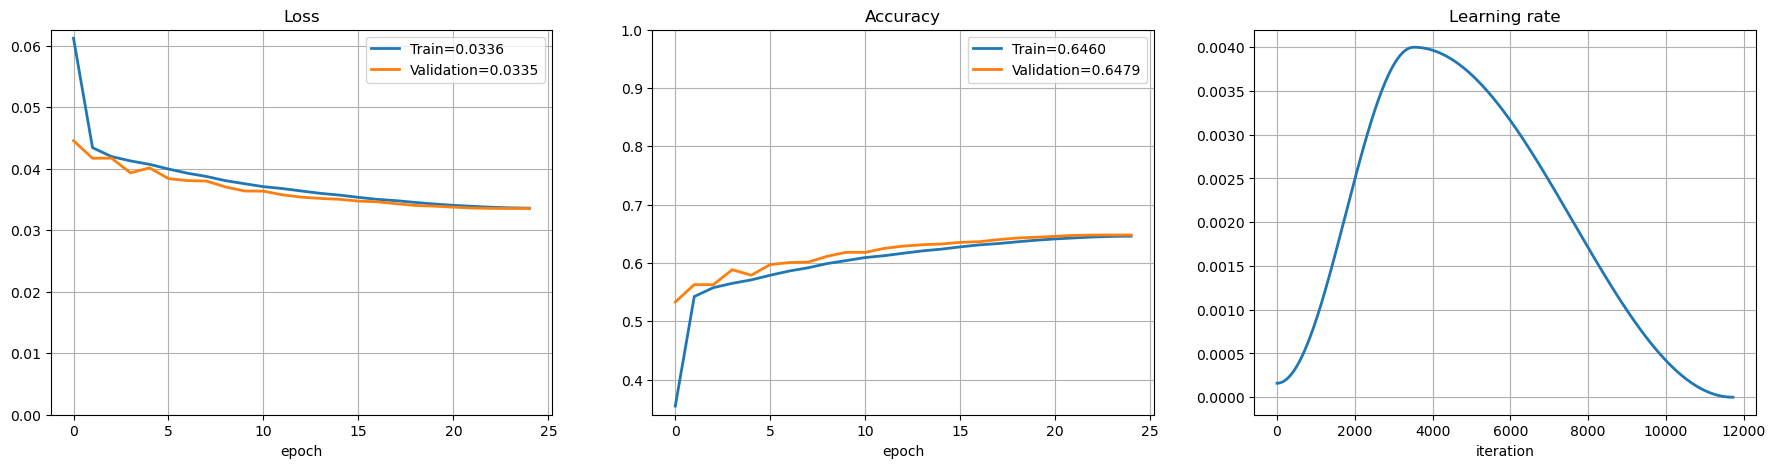

In [15]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

In [ ]:
#-- Run this to load a trained model:
# oModel = GetModel()
# oModel.load_state_dict(torch.load('AE.pt'))
# oModel.to(device)
# oModel.train(False)
# print()

#### Test the model on a single image:

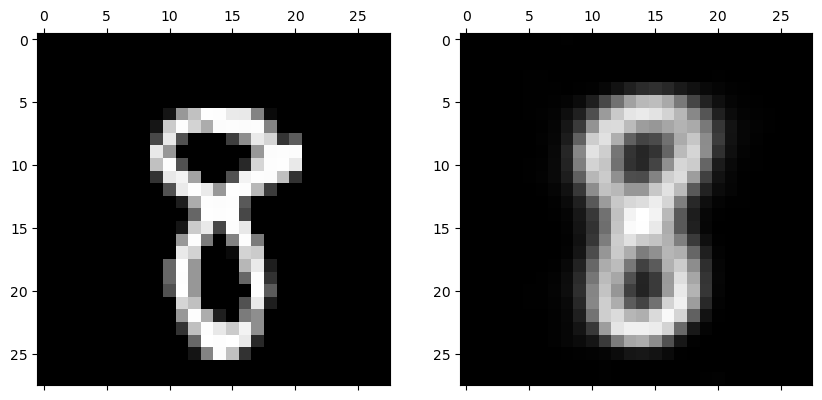

In [28]:
nTest = len(oTestSet)
idx   = np.random.randint(nTest)
mX, _ = oTestSet[idx]
with torch.no_grad():
    mHatX = oModel(mX[None,...].to(DEVICE)).squeeze()

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].matshow(mX[0],       cmap='gray')
ax[1].matshow(mHatX.cpu(), cmap='gray')
plt.show()

#### Encode the train\test data:

In [29]:
K         = 2000
oTrainDL2 = torch.utils.data.DataLoader(oTrainSet, shuffle=True, batch_size=K)
oTestDL2  = torch.utils.data.DataLoader(oTestSet,  shuffle=True, batch_size=K)

mTrainX, vTrainY = next(iter(oTrainDL2))
mTestX,  vTestY  = next(iter(oTestDL2))
oModel.to(DEVICE)

oEncoder = oModel[1]
with torch.no_grad():
    mTrainZ  = oEncoder(mTrainX.to(DEVICE)).cpu().numpy()
    mTestZ   = oEncoder(mTestX.to (DEVICE)).cpu().numpy()

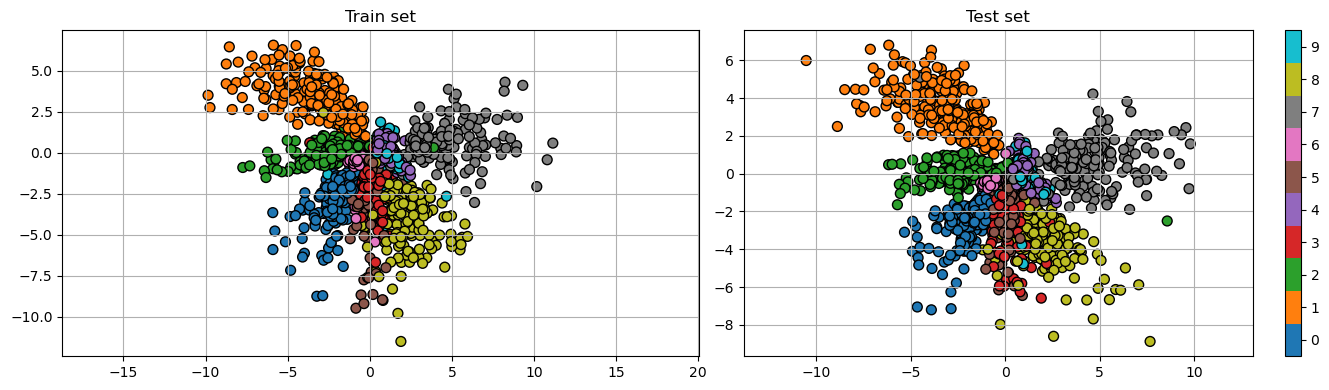

In [33]:
_, ax = plt.subplots(1, 2, figsize=(14, 4))

h1 = ax[0].scatter(mTrainZ[:,0], mTrainZ[:,1], s=50, c=vTrainY, edgecolor='k', cmap='tab10')
h2 = ax[1].scatter(mTestZ [:,0], mTestZ [:,1], s=50, c=vTestY,  edgecolor='k', cmap='tab10', vmin=-.5, vmax=9.5)
ax[0].set_title   ('Train set')
ax[1].set_title   ('Test set')
ax[0].axis        ('equal')
ax[1].axis        ('equal')
ax[0].grid        ()
ax[1].grid        ()

plt.colorbar    (h2, ticks=range(10))
plt.tight_layout()
plt.show        ()

#### Decode a 2D grid:

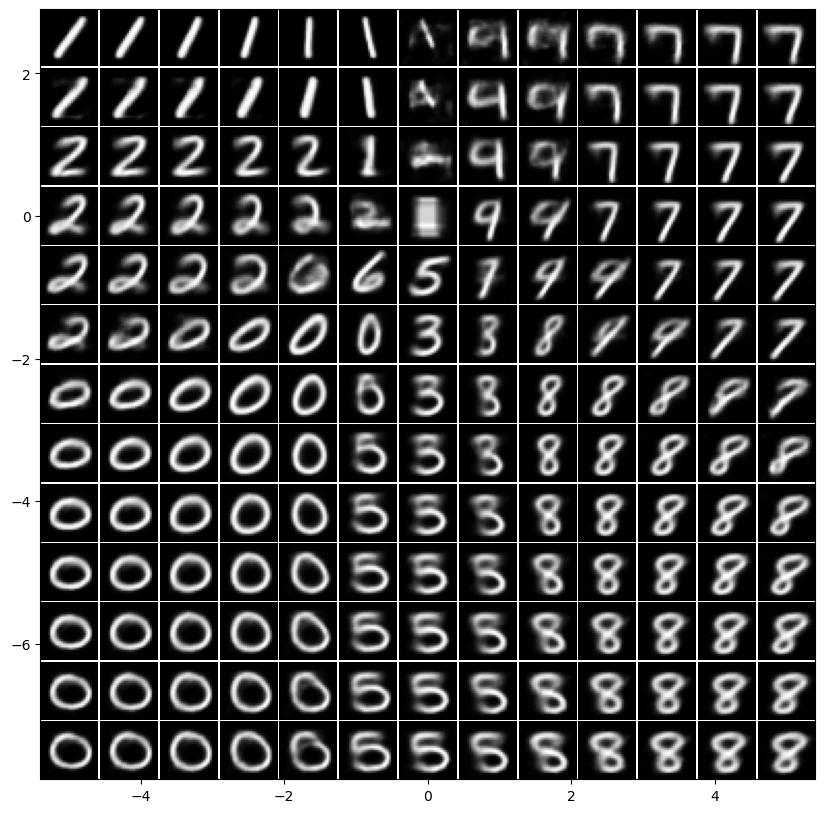

In [40]:
oDecoder   = oModel[2]
v1         = torch.linspace(-5,   5,   13)
v2         = torch.linspace(-7.5, 2.5, 13)
mZZ1, mZZ2 = torch.meshgrid(v1, v2)
mZZ        = torch.stack   ([mZZ1.ravel(), mZZ2.ravel()], dim=1)

with torch.no_grad():
    mHatX = oDecoder(mZZ.to(DEVICE)).cpu().squeeze()

M    = mZZ.shape[0]
size = .4
fig  = plt.figure(figsize=(10, 10))
for ii in range(M):
    x0  = mZZ[ii,0] - size
    x1  = mZZ[ii,0] + size
    y0  = mZZ[ii,1] - size
    y1  = mZZ[ii,1] + size
    plt.imshow(mHatX[ii,:,:], aspect='auto', cmap='gray', zorder=1, extent=(x0, x1, y0, y1))

plt.axis('tight')
plt.show()

### Outliers detection:

In [66]:
K        = 250
oTestDL2 = torch.utils.data.DataLoader(oTestSet, shuffle=True, batch_size=K)
mX2, _   = next(iter(oTestDL2))

#-- Generate M outliers:
M              = 50 
mX2[-M:,:,:,:] = torch.randn(M, 1, 28, 28)

#### Compute reconstruction error:

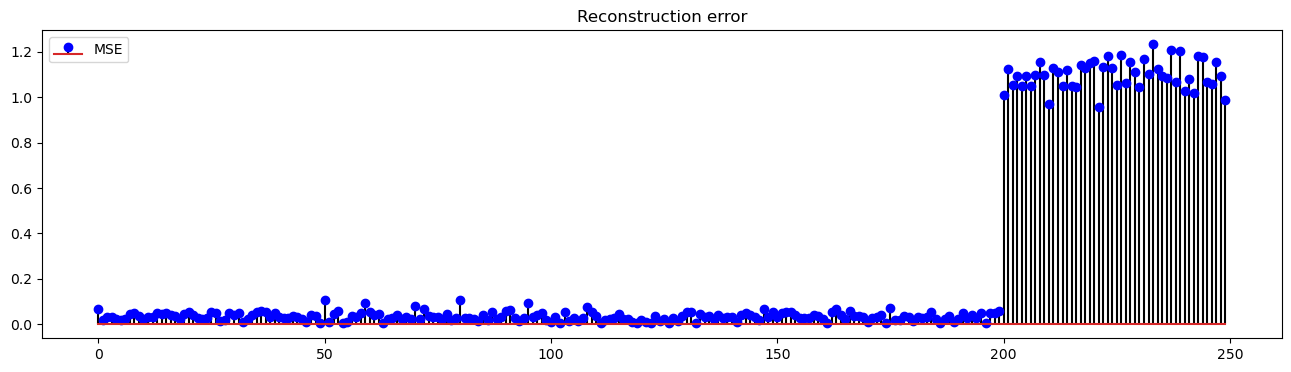

In [67]:
with torch.no_grad():
    mHatX2 = oModel(mX2.to(DEVICE)).cpu()

vMSE = nn.MSELoss(reduction='none')(mX2, mHatX2).mean(dim=(1,2,3))

plt.figure(figsize=(16, 4))
plt.stem  (vMSE, linefmt='k', markerfmt='ob', use_line_collection=True, label='MSE')
plt.title ('Reconstruction error')
plt.legend()
plt.show  ()